In [1]:
##############################################################################
### Using conda environment "planetary_computer" load the following modules
##############################################################################

import planetary_computer
import pystac_client
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps


In [2]:
##############################################################################
### Select a day for which CONUS404 precipitation will be shown
##############################################################################

day = '2017-08-27'


In [3]:
%%time
##############################################################################
### Load the entire CONUS404 dataset (takes ~1 min)
##############################################################################

# Pulling data down from the cloud
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier=planetary_computer.sign_inplace,)
c = catalog.get_collection("conus404")
asset = c.assets["zarr-abfs"]

# Open the dataset
ds = xr.open_zarr(asset.href,storage_options=asset.extra_fields["xarray:storage_options"],
                  **asset.extra_fields["xarray:open_kwargs"],)
print(ds)


<xarray.Dataset>
Dimensions:         (time: 376944, south_north: 1015, west_east: 1367,
                     bottom_top: 50, soil_layers_stag: 4, snow_layers_stag: 3,
                     west_east_stag: 1368, south_north_stag: 1016,
                     bottom_top_stag: 51, snso_layers_stag: 7)
Coordinates:
    lat             (south_north, west_east) float32 dask.array<chunksize=(882, 1188), meta=np.ndarray>
    lat_u           (south_north, west_east_stag) float32 dask.array<chunksize=(882, 1188), meta=np.ndarray>
    lat_v           (south_north_stag, west_east) float32 dask.array<chunksize=(883, 1187), meta=np.ndarray>
    lon             (south_north, west_east) float32 dask.array<chunksize=(882, 1188), meta=np.ndarray>
    lon_u           (south_north, west_east_stag) float32 dask.array<chunksize=(882, 1188), meta=np.ndarray>
    lon_v           (south_north_stag, west_east) float32 dask.array<chunksize=(883, 1187), meta=np.ndarray>
  * time            (time) datetime64[ns] 1979

In [4]:
%%time
##############################################################################
### Load precipitation data for the specified day
##############################################################################

# Create time array with timestamp at beginning of accum period to be used in sum (day 0h to day 23h)
accum_beg = pd.date_range(start=pd.to_datetime(day),end=pd.to_datetime(day)+pd.Timedelta(hours=23),freq='1h')

# Read in precipitation data for the specified day and hour0 on the day after to account for accum period
prec_accum_end = ds['PREC_ACC_NC'].sel(time=slice(pd.to_datetime(day),pd.to_datetime(day)+pd.Timedelta(hours=24)))
prec_accum_beg = prec_accum_end.isel(time=slice(1,None)).assign_coords(time=accum_beg) # reshuffle times up 1h

# Compute daily sum
prec_daily = prec_accum_beg.resample(time='1D').sum().compute()
print(prec_daily)


<xarray.DataArray 'PREC_ACC_NC' (time: 1, south_north: 1015, west_east: 1367)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
    lat      (south_north, west_east) float32 17.65 17.66 17.67 ... 51.71 51.69
    lon      (south_north, west_east) float32 -122.6 -122.5 ... -57.12 -57.07
  * time     (time) datetime64[ns] 2017-08-27
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  ACCUMULATED GRID SCALE  PRECIPITATION OVER prec_acc_dt PERI...
    long_name:    Accumulated grid scale  precipitation , accumulated over pr...
    stagger:      
    units:        mm
CPU times: user 1.4 s, sys: 476 ms, total: 1.88 s
Wall time: 3.71 s


CPU times: user 962 ms, sys: 46.8 ms, total: 1.01 s
Wall time: 1.04 s


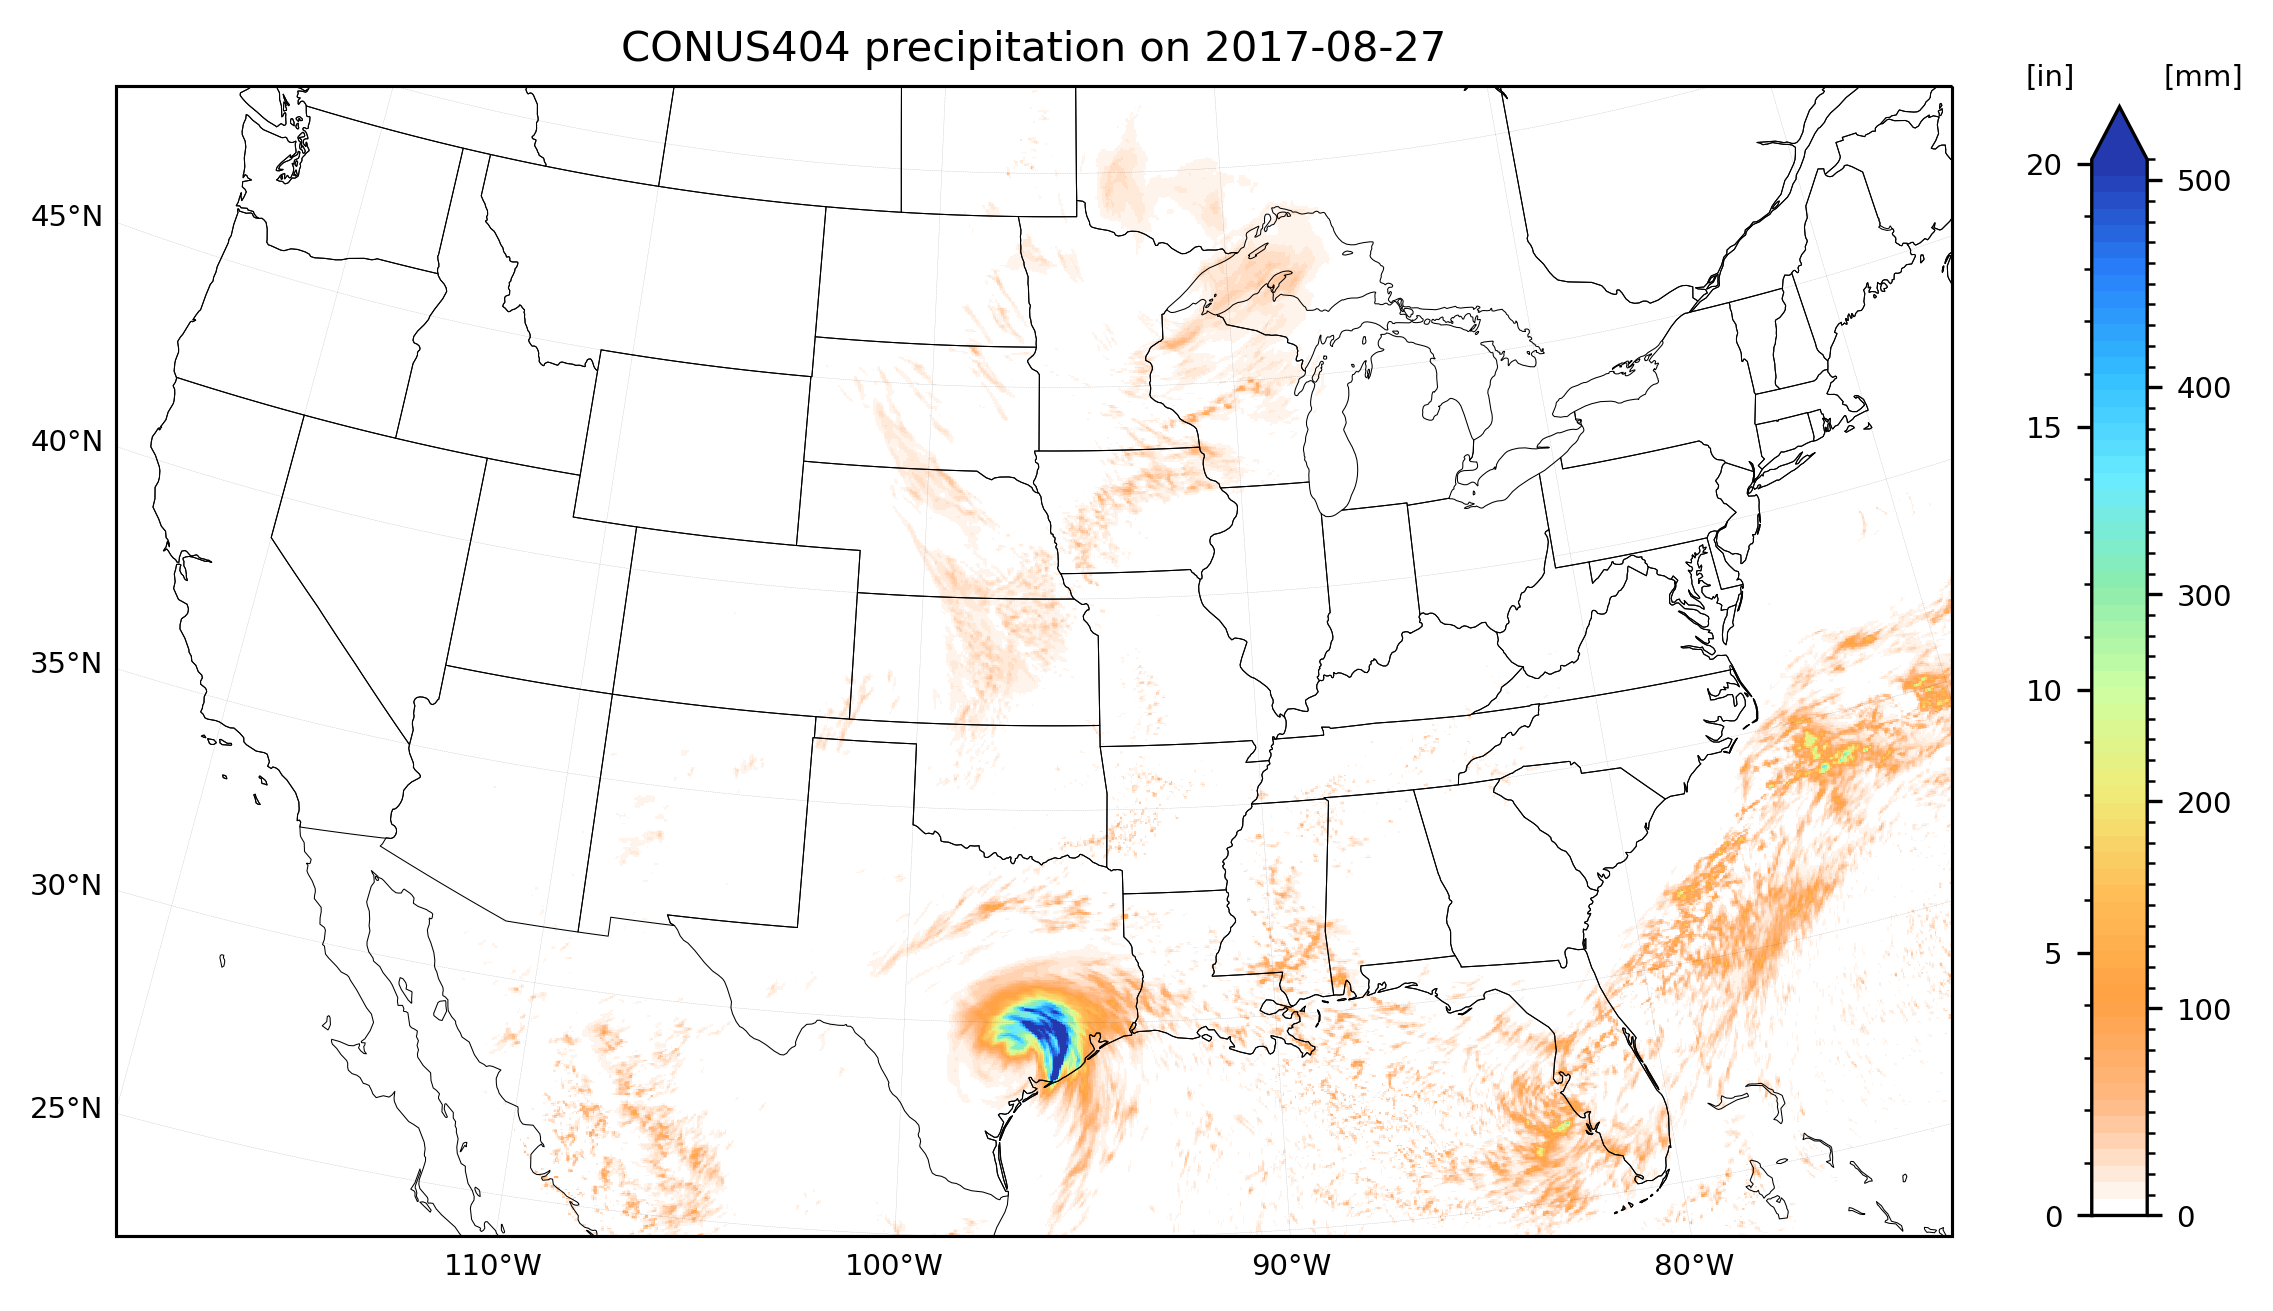

In [16]:
%%time
##############################################################################
### Plot the data
##############################################################################

# Figure parameters
mpl.colormaps.unregister('cmp_haxby_r')    # need to unregister before use for cmaps
cmap = cmaps.cmp_haxby_r                   # color bar
data_proj = ccrs.PlateCarree()             # data projection
map_proj  = ccrs.LambertConformal()        # map projection

# Make figure
figw, figh, dpi = 10, 6, 300
fig, ax = plt.subplots(figsize=(figw,figh),dpi=dpi,subplot_kw={'projection':map_proj})
ax.set_title(f'CONUS404 precipitation on {day}',fontsize=10,pad=6)

# Plot specs
ax.set_extent([-120,-73,25,50],data_proj)
ax.add_feature(cfeature.COASTLINE,linewidths=0.25)
ax.add_feature(cfeature.STATES,linewidths=0.25)

# Plot data
plot = ax.pcolormesh(prec_daily.lon,prec_daily.lat,prec_daily.isel(time=0).values,
                     cmap=cmap,transform=data_proj,vmax=510) 

# Color bar
cbar = plt.colorbar(plot,ax=ax,orientation='vertical',shrink=0.8,pad=0.06,ticks=mpl.ticker.MultipleLocator(100),
                    extend='max')
cbar.ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
cbar.ax.tick_params(labelsize=7)
ax.text(1.115,1.0,'[mm]',fontsize=7,transform=ax.transAxes)

# Add inches to left side of colorbar
def mm_to_inches(mm):
    return mm / 25.4
inches = cbar.ax.secondary_yaxis('left',functions=(mm_to_inches,lambda x: x * 25.4))
inches.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
inches.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
inches.tick_params(labelsize=7)
ax.text(1.04,1.0,'[in]',fontsize=7,transform=ax.transAxes)

# Ticks and gridlines
gl = ax.gridlines(crs=data_proj,draw_labels=True,alpha=0.25,lw=0.1,color='k',linestyle='--',
                  x_inline=False,y_inline=False)
gl.top_labels, gl.bottom_labels, gl.left_labels, gl.right_labels = False, True, True, False
gl.ylocator, gl.xlocator = mpl.ticker.MultipleLocator(5.), mpl.ticker.MultipleLocator(10.)
gl.ylabel_style = {'size':7,'rotation':0,'ha':'right','va':'center'}
gl.xlabel_style = {'size':7,'rotation':0,'ha':'center','va':'top'}
gl.ypadding, gl.xpadding = 3, 4

# Figure frame
for spine in ax.spines.values():
    spine.set_linewidth(0.75)
    